<a href="https://colab.research.google.com/github/sivaprasadt246/Automatic_Ticket_Classification_Assignment/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import en_core_web_sm
nlp = en_core_web_sm.load()

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

# Opening JSON file 
root_path = "/content/gdrive/MyDrive/NLP_Assignment/complaints-2021-05-14_08_16.json"
#root_path = 'complaints-2021-05-14_08_16.json'
f = open(root_path)
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

Mounted at /content/gdrive


## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#shape of dataframe
df.shape

(78313, 22)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [10]:
#Assign new column names
#renaming the column names for better readability

df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]

df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [11]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

57241

In [12]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()

0

In [13]:
df.head (5)

,complaint_text,category,sub_category
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*?\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [15]:
df.complaint_text.head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_text, dtype: object

In [16]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [17]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [18]:
#nlp = en_core_web_sm.load(disable = ['ner', 'parser'])
#print(nlp.pipe_names)

In [19]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words

def lemmatizer(text):
    doc = nlp(text)
    lemmatized_output = ' '.join([token.lemma_ for token in doc if not token.text in set(stopwords)])
    return lemmatized_output

In [20]:
df['lemmatized_complaint'] =  df.complaint_text.apply(lambda x: lemmatizer(x))
df.head(5)

,complaint_text,category,sub_category,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,Debt collection,Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card,General-purpose credit card or charge card,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",Credit reporting,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account,Checking account,grand son check deposit chase account fund cle...


In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_text','lemmatized_complaint']]
df_clean.head()

,complaint_text,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [22]:
#Write your function to extract the POS tags 
nlp = en_core_web_sm.load()

def extract_pos_tags(text):
    doc = nlp(text)
    tag_nn = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(tag_nn)

df_clean["complaint_POS_removed"] = df_clean.lemmatized_complaint.apply(lambda x: extract_pos_tags(x))
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([4.187e+03, 5.253e+03, 3.788e+03, 2.566e+03, 1.592e+03, 1.042e+03,
        7.120e+02, 5.250e+02, 4.410e+02, 3.000e+02, 1.390e+02, 1.160e+02,
        7.400e+01, 5.900e+01, 3.900e+01, 3.200e+01, 2.900e+01, 2.600e+01,
        2.600e+01, 1.800e+01, 1.400e+01, 1.200e+01, 5.000e+00, 8.000e+00,
        1.000e+00, 5.000e+00, 9.000e+00, 3.000e+00, 1.000e+01, 2.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

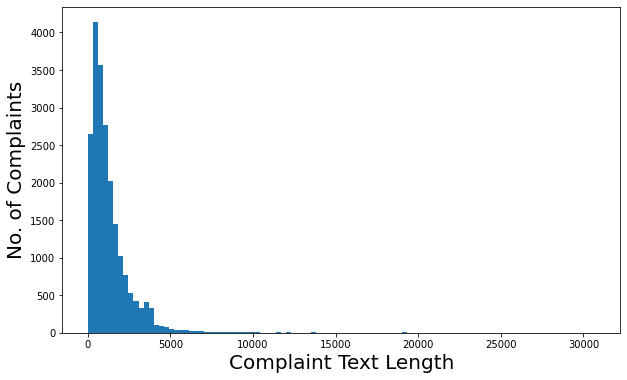

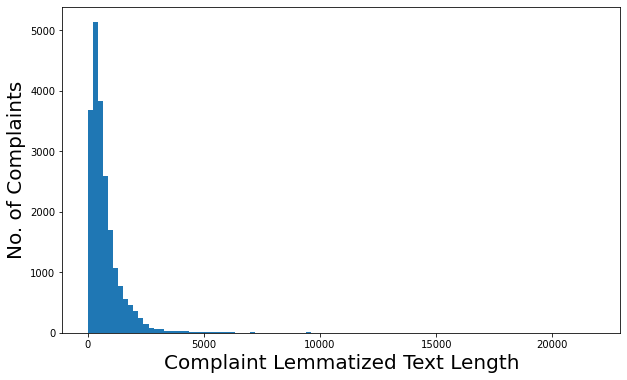

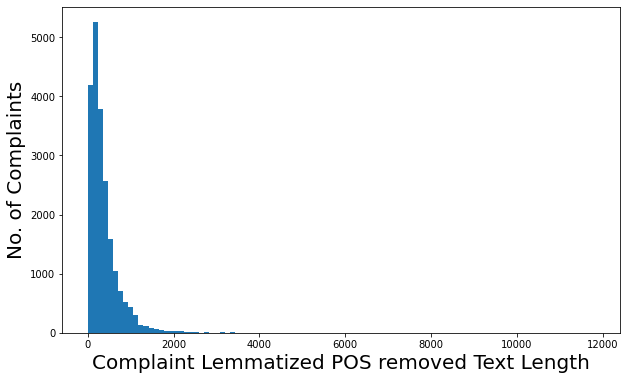

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_text]

plt.xlabel('Complaint Text Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.hist(doc_lens, bins = 100)

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.lemmatized_complaint]

plt.xlabel('Complaint Lemmatized Text Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.hist(doc_lens, bins = 100)

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]

plt.xlabel('Complaint Lemmatized POS removed Text Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.hist(doc_lens, bins = 100)

In [25]:
#!pip install wordcloud

#### Find the top 40 words by frequency among all the articles after processing the text.

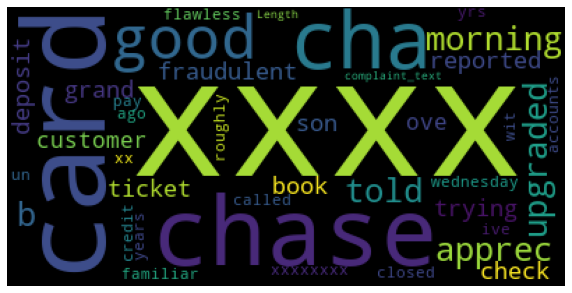

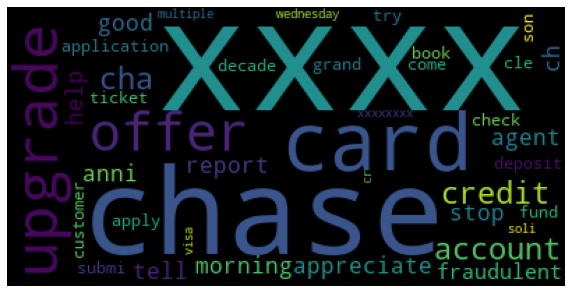

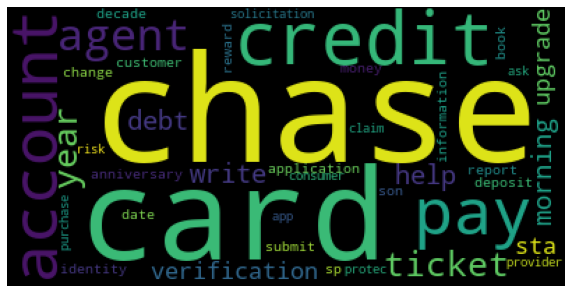

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_text))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.lemmatized_complaint))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [27]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...


In [28]:
# Top n bigram function

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)

In [30]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams: ')
top_30_unigrams[:10]

Top 10 unigrams: 


[('chase', 55432),
 ('account', 39629),
 ('credit', 32437),
 ('card', 29064),
 ('payment', 20207),
 ('charge', 16515),
 ('time', 15229),
 ('money', 11670),
 ('day', 11661),
 ('bank', 11149)]

In [31]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)

In [32]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams: ')
top_30_bigrams[:10]

Top 10 bigrams: 


[('credit card', 12175),
 ('credit report', 3618),
 ('chase credit', 3137),
 ('customer service', 2715),
 ('account chase', 2658),
 ('chase account', 2182),
 ('contact chase', 1932),
 ('debit card', 1912),
 ('account account', 1838),
 ('chase bank', 1770)]

In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [34]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams: ')
top_30_trigrams[:10]

Top 10 trigrams: 


[('chase credit card', 2161),
 ('credit card account', 986),
 ('credit card company', 958),
 ('credit card chase', 815),
 ('chase customer service', 509),
 ('charge credit card', 496),
 ('inquiry credit report', 456),
 ('credit card credit', 454),
 ('account credit card', 358),
 ('credit card charge', 356)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [35]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [36]:
#All masked texts has been removed
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [37]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [38]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean) 

tfidf.get_feature_names()[:10]


['aarp',
 'abate',
 'abatement',
 'abbreviation',
 'abet',
 'abhorrent',
 'abide',
 'ability',
 'abovereference',
 'absence']

In [39]:
len(tfidf.get_feature_names())

6118

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics =  5 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

#W1 = nmf_model.fit_transform(dtm)
#H1 = nmf_model.components_

In [42]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

6118

In [43]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['business', 'claim', 'transaction', 'checking', 'number', 'transfer', 'day', 'branch', 'fund', 'bank', 'deposit', 'chase', 'money', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['remove', 'year', 'letter', 'application', 'limit', 'debt', 'information', 'company', 'account', 'score', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['error', 'year', 'mortgage', 'date', 'chase', 'credit', 'auto', 'day', 'time', 'fee', 'statement', 'month', 'pay', 'balance', 'payment']


TOP 15 WORDS FOR TOPIC #3
['time', 'pay', 'overdraft', 'claim', 'service', 'balance', 'refund', 'merchant', 'purchase', 'transaction', 'dispute', 'chase', 'card', 'fee', 'charge']


TOP 15 WORDS FOR TOPIC #4
['information', 'sale', 'foreclosure', 'request', 'time', 'rate', 'letter', 'document', 'year', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']




In [44]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([4, 0, 1, ..., 0, 2, 2])

In [45]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)

In [46]:
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0


In [47]:
#Print the first 5 Complaint for each of the Topics
temp=df_clean.groupby('Topic').head(5)
temp.sort_values('Topic')

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,term account deposit bonus pay day deposit acc...,term account deposit bonus pay day deposit acc...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,account chase auto,account chase auto,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...,1
15,can you please remove inquiry,remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,chase credit card credit report company issue,chase credit card credit report company issue,1
26,i have reached out to xxxx several times in at...,reach xxxx time attempt fraudulent inquiry rem...,time attempt inquiry remove contact creditor p...,time attempt inquiry remove contact creditor p...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [48]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [49]:
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,Bank Account services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...,Bank Account services
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,Others


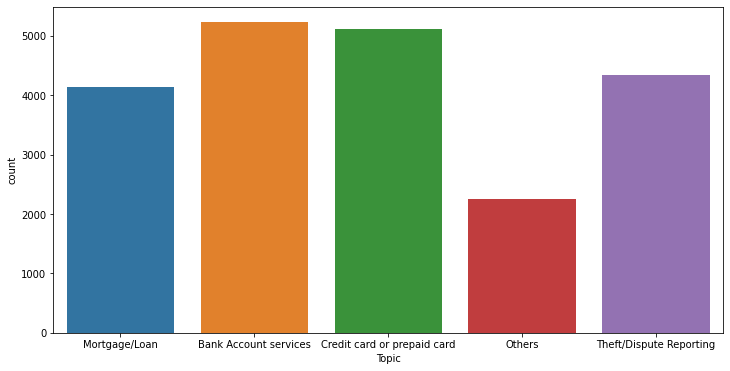

In [50]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic', data=df_clean)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,3
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...,0
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,2


In [53]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_text','Topic']]

In [54]:
training_data

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i...,1
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,0
78311,i have had flawless credit for yrs ive had cha...,2


In [55]:
# x - y  split
X = training_data.complaint_text
y = training_data.Topic

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [56]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [57]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [59]:
# utlity function to display the model report

def display_classification_report(model,metric):
    
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();


In [60]:
# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [61]:
# utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [62]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.7574031411306308
Best Hyperparameters:  {'alpha': 0.01}
ROC AUC Score Train: 0.99
ROC AUC Score Test: 0.94
Train Accuracy : 0.89
Test Accuracy : 0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      3923
           1       0.87      0.90      0.89      3833
           2       0.92      0.78      0.85      1688
           3       0.89      0.91      0.90      3259
           4       0.93      0.89      0.91      3101

    accuracy                           0.89     15804
   macro avg       0.90      0.88      0.89     15804
weighted avg       0.90      0.89      0.89     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1307
           1       0.75      0.74      0.74      1277
           2       0.71      0.48      0.57       563
  

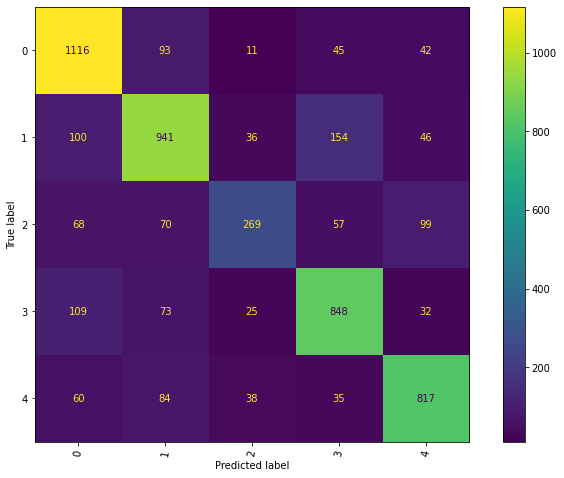

In [63]:
# MODE1: Multinomial Naive Bayes with GridSearchCV

mnb = MultinomialNB()

mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}

# create gridsearch object
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring=None)

# fit model
grid_search_mnb.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_mnb)

# Random Forest Classification Report
metric1=[]
display_classification_report(grid_search_mnb,metric1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.9262843636247142
Best Hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy : 0.94
Test Accuracy : 0.94
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      3923
           1       0.94      0.95      0.94      3833
           2       0.94      0.92      0.93      1688
           3       0.94      0.94      0.94      3259
           4       0.94      0.94      0.94      3101

    accuracy                           0.94     15804
   macro avg       0.94      0.94      0.94     15804
weighted avg       0.94      0.94      0.94     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      1307
           1       0.94      0.94      0.94      1277
           2       0.96      

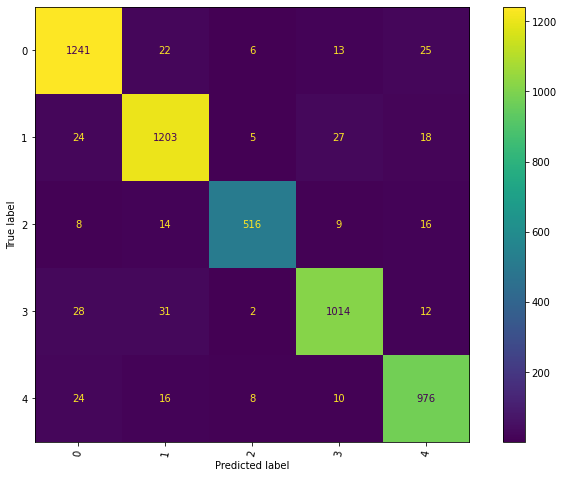

In [64]:
# Logistic Regression with GridSearchCV

# logistic regression
log_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# Random Forest Classification Report
metric2=[]
display_classification_report(grid_search_log,metric2)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.9396046310566761
Best Hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 30}
ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.94
Train Accuracy : 0.83
Test Accuracy : 0.8
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3923
           1       0.85      0.87      0.86      3833
           2       0.82      0.76      0.79      1688
           3       0.83      0.77      0.80      3259
           4       0.80      0.86      0.83      3101

    accuracy                           0.83     15804
   macro avg       0.83      0.82      0.82     15804
weighted avg       0.83      0.83      0.83     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80      1307
           1       0.82      0.85      0.83      1277
           2       0.79      0

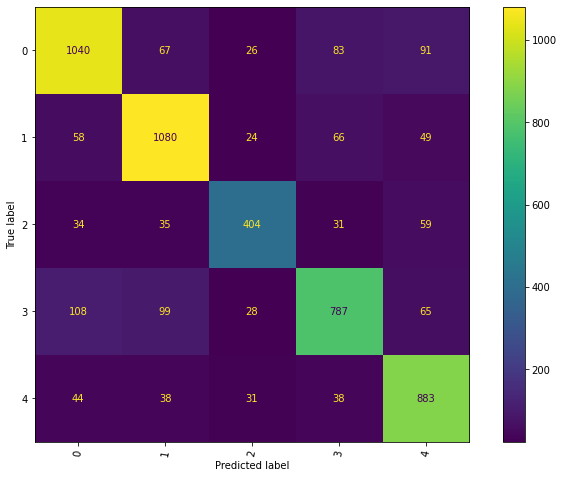

In [65]:
# Decision Tree Classification wuth GridSearchCV

dtc = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30]
}

# create gridsearch object
grid_search_dtc = grid_search(dtc, folds, dtc_params, scoring='roc_auc_ovr')

# fit model
grid_search_dtc.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_dtc)

# Random Forest Classification Report
metric3=[]
display_classification_report(grid_search_dtc,metric3)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
OOB SCORE : 0.7478486459124273
Best Score:  0.9646279487946021
Best Hyperparameters:  {'max_depth': 30, 'min_samples_leaf': 15, 'n_estimators': 200}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.96
Train Accuracy : 0.8
Test Accuracy : 0.75
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      3923
           1       0.72      0.91      0.81      3833
           2       1.00      0.17      0.29      1688
           3       0.86      0.80      0.83      3259
           4       0.85      0.81      0.83      3101

    accuracy                           0.80     15804
   macro avg       0.84      0.73      0.72     15804
weighted avg       0.82      0.80      0.77     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.74      0.91      0.81      1307
           1       0.67      0.8

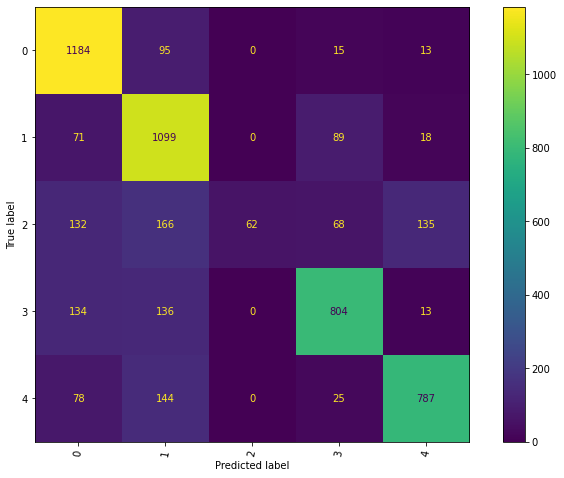

In [67]:
# Random Forest Classifier with GridSearchCV

rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30],
          'min_samples_leaf': [15,20,30],
          'n_estimators': [100,200]
        }

# create gridsearch object
grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')

# fit model
grid_search_rfc.fit(X_train, y_train)

# oob score
print('OOB SCORE :',grid_search_rfc.best_estimator_.oob_score_)

# print best hyperparameters
print_best_score_params(grid_search_rfc)

# Random Forest Classification Report
metric4=[]
display_classification_report(grid_search_rfc,metric4)

In [71]:
# Consolidated view of all the models and their metrics

table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ], 
        'Multinomial Naive Bayes with GridSearchCV': metric1
        }

grid_mnb_metric = pd.DataFrame(table ,columns = ['Metric', 'Multinomial Naive Bayes with GridSearchCV'] )

#grid_mnb_metric = pd.Series(metric1, name = 'Multinomial Naive Bayes with GridSearchCV')
grid_log_metric = pd.Series(metric2, name = 'Logistic Regression with GridSearchCV')
grid_dtc_metric = pd.Series(metric3, name = 'Decision Tree Classifier with GridSearchCV')
grid_rfc_metric = pd.Series(metric4, name = 'Random Forest Classifier with GridSearchCV')

final_metric = pd.concat([grid_mnb_metric,grid_log_metric,grid_dtc_metric,grid_rfc_metric], axis = 1)
final_metric

,Metric,Multinomial Naive Bayes with GridSearchCV,Logistic Regression with GridSearchCV,Decision Tree Classifier with GridSearchCV,Random Forest Classifier with GridSearchCV
0,ROC_AUC Score(Train),0.99,1.00,0.97,0.98
1,ROC_AUC Score(Test),0.94,1.00,0.94,0.96
2,Accuracy(Train),0.89,0.94,0.83,0.80
3,Accuracy(Test),0.76,0.94,0.80,0.75
4,Precision(Train),0.90,0.94,0.83,0.82
5,Precision(Test),0.76,0.94,0.80,0.78
6,Recall(Train),0.89,0.94,0.83,0.80
7,Recall(Test),0.76,0.94,0.80,0.75
8,F1-Score(Train),0.89,0.94,0.83,0.77
9,F1-Score(Test),0.75,0.94,0.80,0.72


## Logistic Regression with GridCV giving better results

In [81]:
## TEST1

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

test_complaint= 'I want to open a salary account at your downtown branch. Please provide me the procedure'

# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

prediction=grid_search_log.predict(test_tfidf)
Topic_names[prediction[0]]

'Bank Account services'

In [82]:
##TEST 2

test_complaint= 'The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest'

# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

prediction=grid_search_log.predict(test_tfidf)
Topic_names[prediction[0]]

'Credit card or prepaid card'

In [84]:
##TEST 3

test_complaint= 'I tried to make a transaction at a supermarket retail store using my debit card, but the transaction was declined. Please resolve this issue.'

# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

prediction=grid_search_log.predict(test_tfidf)
Topic_names[prediction[0]]

'Theft/Dispute Reporting'